In [ ]:
%load_ext autoreload
%autoreload 2

# IQA tracking params and variables

> When using parametric layers we have to be able to keep track of the parameters and the variables of the model (which are not going to be trained). We're going to play with this concept using our implementation of the functional layers.

In [ ]:
# import os; os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".99"

In [ ]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from typing import Any, Callable, Sequence, Union
import numpy as np

import tensorflow as tf
tf.config.set_visible_devices([], device_type='GPU')

import jax
from jax import lax, random, numpy as jnp
import flax
from flax.core import freeze, unfreeze, FrozenDict
from flax import linen as nn
from flax import struct
from flax.training import train_state
from flax.training import orbax_utils

import optax
import orbax.checkpoint

from clu import metrics
from ml_collections import ConfigDict

from einops import reduce, rearrange
import wandb
from iqadatasets.datasets import *
from fxlayers.layers import *
from fxlayers.layers import GaussianLayerGamma, FreqGaussianGamma, OrientGaussianGamma
from fxlayers.initializers import *
from JaxPlayground.utils.constraints import *
from JaxPlayground.utils.wandb import *

In [ ]:
# jax.config.update("jax_debug_nans", False)

## Load the data

> We're going to employ `iqadatasets` to ease the loading of the data.

In [ ]:
dst_train = TID2008("/lustre/ific.uv.es/ml/uv075/Databases/IQA//TID/TID2008/", exclude_imgs=[25])
# dst_train = KADIK10K("/lustre/ific.uv.es/ml/uv075/Databases/IQA/KADIK10K/")
dst_val = TID2013("/lustre/ific.uv.es/ml/uv075/Databases/IQA//TID/TID2013/", exclude_imgs=[25])
# dst_train = TID2008("/media/disk/databases/BBDD_video_image/Image_Quality//TID/TID2008/", exclude_imgs=[25])
# dst_val = TID2013("/media/disk/databases/BBDD_video_image/Image_Quality//TID/TID2013/", exclude_imgs=[25])
# dst_train = TID2008("/media/databases/IQA/TID/TID2008/", exclude_imgs=[25])
# dst_val = TID2013("/media/databases/IQA/TID/TID2013/", exclude_imgs=[25])

In [1]:
img, img_dist, mos = next(iter(dst_train.dataset))
img.shape, img_dist.shape, mos.shape

(TensorShape([384, 512, 3]), TensorShape([384, 512, 3]), TensorShape([]))

In [2]:
img, img_dist, mos = next(iter(dst_val.dataset))
img.shape, img_dist.shape, mos.shape

(TensorShape([384, 512, 3]), TensorShape([384, 512, 3]), TensorShape([]))

In [3]:
config = {
    "BATCH_SIZE": 64,
    "EPOCHS": 500,
    "LEARNING_RATE": 3e-2,
    "SEED": 42,
    "GDN_CLIPPING": True,
    "NORMALIZE_PROB": False,
    "NORMALIZE_ENERGY": True,
    "ZERO_MEAN": True,
    "USE_BIAS": False,
    "CS_KERNEL_SIZE": 21,
    "GDNGAUSSIAN_KERNEL_SIZE": 11,
    "GABOR_KERNEL_SIZE": 31,
    # "N_SCALES": 4,
    # "N_ORIENTATIONS": 16,
    "N_GABORS": 128,
    "INIT_JH": True,
    "TRAIN_JH": False,
    "A_GABOR": True,
    "A_GDNSPATIOFREQORIENT": True,
}
config = ConfigDict(config)
config

A_GABOR: true
A_GDNSPATIOFREQORIENT: true
BATCH_SIZE: 64
CS_KERNEL_SIZE: 21
EPOCHS: 500
GABOR_KERNEL_SIZE: 31
GDNGAUSSIAN_KERNEL_SIZE: 11
GDN_CLIPPING: true
INIT_JH: true
LEARNING_RATE: 0.03
NORMALIZE_ENERGY: true
NORMALIZE_PROB: false
N_GABORS: 128
SEED: 42
TRAIN_JH: false
USE_BIAS: false
ZERO_MEAN: true

In [4]:
wandb.init(project="PerceptNet_v15",
           name="V19_128GaborFree_A_J&HFixed",
           job_type="training",
           config=config,
           mode="online",
           )
config = config
config

wandb: Currently logged in as: jorgvt. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.16.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.15.1
wandb: Run data is saved locally in /lhome/ext/uv075/uv0752/perceptnet/Notebooks/13_JaX/13_07_V19_GaborFree/wandb/run-20240214_125321-qrb7yi0h
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run V19_128GaborFree_A_J&HFixed
wandb:  View project at https://wandb.ai/jorgvt/PerceptNet_v15
wandb:  View run at https://wandb.ai/jorgvt/PerceptNet_v15/runs/qrb7yi0h


A_GABOR: true
A_GDNSPATIOFREQORIENT: true
BATCH_SIZE: 64
CS_KERNEL_SIZE: 21
EPOCHS: 500
GABOR_KERNEL_SIZE: 31
GDNGAUSSIAN_KERNEL_SIZE: 11
GDN_CLIPPING: true
INIT_JH: true
LEARNING_RATE: 0.03
NORMALIZE_ENERGY: true
NORMALIZE_PROB: false
N_GABORS: 128
SEED: 42
TRAIN_JH: false
USE_BIAS: false
ZERO_MEAN: true

In [ ]:
dst_train_rdy = dst_train.dataset.shuffle(buffer_size=100,
                                      reshuffle_each_iteration=True,
                                      seed=config.SEED)\
                                 .batch(config.BATCH_SIZE, drop_remainder=True)
dst_val_rdy = dst_val.dataset.batch(config.BATCH_SIZE, drop_remainder=True)

## Define the model we're going to use

> It's going to be a very simple model just for demonstration purposes.

In [ ]:
#| exporti
class FreqOrientGaussianGamma(nn.Module):
    """(1D) Gaussian interaction between frequencies and orientations optimizing gamma = 1/sigma instead of sigma."""
    use_bias: bool = False
    strides: int = 1
    padding: str = "SAME"
    bias_init: Callable = nn.initializers.zeros_init()

    @nn.compact
    def __call__(self,
                 inputs,
                 fmean,
                 theta_mean,
                 **kwargs,
                 ):
        gamma_f = self.param("gamma_f",
                             k_array(1/0.4, arr=fmean),
                             (inputs.shape[-1],))
        gamma_theta = self.param("gamma_theta",
                                 equal_to(jnp.ones(shape=(len(theta_mean),)) * (1/20)),
                                 (inputs.shape[-1],))
        if self.use_bias: bias = self.param("bias",
                                            self.bias_init,
                                            (len(fmean),))
        else: bias = 0.
        # n_groups = inputs.shape[-1] // len(fmean)
        kernel = jax.vmap(self.gaussian, in_axes=(None,None,0,0,0,0,None), out_axes=1)(fmean, theta_mean, fmean, theta_mean, gamma_f, gamma_theta, 1)
        kernel = kernel[None,None,:,:]
        # kernel = jnp.tile(kernel, reps=n_groups)

        ## Add the batch dim if the input is a single element
        if jnp.ndim(inputs) < 4: inputs = inputs[None,:]; had_batch = False
        else: had_batch = True
        outputs = lax.conv_general_dilated(
                jnp.transpose(inputs,[0,3,1,2]),    # lhs = NCHW image tensor
                jnp.transpose(kernel,[3,2,0,1]), # rhs = OIHW conv kernel tensor
                (self.strides, self.strides),
                self.padding)
        ## Move the channels back to the last dim
        outputs = jnp.transpose(outputs, (0,2,3,1))
        if not had_batch: outputs = outputs[0]
        return outputs + bias

    @staticmethod
    def gaussian(f, theta, fmean, theta_mean, gamma_f, gamma_theta, A=1):
        return A*jnp.exp(-((gamma_f**2)*(f-fmean)**2)/(2))*jnp.exp(-((gamma_theta**2)*(theta-theta_mean)**2)/(2))

In [ ]:
class GDNSpatioFreqOrient(nn.Module):
    """Generalized Divisive Normalization."""
    kernel_size: Union[int, Sequence[int]]
    strides: int = 1
    padding: str = "SAME"
    # inputs_star: float = 1.
    # outputs_star: Union[None, float] = None
    fs: int = 1
    apply_independently: bool = False
    bias_init: Callable = nn.initializers.ones_init()
    alpha: float = 2.
    epsilon: float = 1/2 # Exponential of the denominator
    eps: float = 1e-6 # Numerical stability in the denominator

    @nn.compact
    def __call__(self,
                 inputs,
                 fmean,
                 theta_mean,
                 train=False,
                 ):
        b, h, w, c = inputs.shape
        bias = self.param("bias",
                          #equal_to(inputs_star/10),
                          self.bias_init,
                          (c,))
        # is_initialized = self.has_variable("batch_stats", "inputs_star")
        # inputs_star = self.variable("batch_stats", "inputs_star", lambda x: jnp.ones(x)*self.inputs_star, (len(self.inputs_star),))
        # inputs_star_ = jnp.ones_like(inputs)*inputs_star.value
        GL = GaussianLayerGamma(features=c, kernel_size=self.kernel_size, strides=self.strides, padding="VALID", fs=self.fs, xmean=self.kernel_size/self.fs/2, ymean=self.kernel_size/self.fs/2, normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, use_bias=False, feature_group_count=c)
        FOG = FreqOrientGaussianGamma()
        outputs = GL(pad_same_from_kernel_size(inputs, kernel_size=self.kernel_size, mode=self.padding)**self.alpha, train=train)#/(self.kernel_size**2)
        outputs = FOG(outputs, fmean=fmean, theta_mean=theta_mean)

        ## Coef
        # coef = GL(inputs_star_**self.alpha, train=train)#/(self.kernel_size**2)
        # coef = FG(coef, fmean=fmean)
        # coef = rearrange(coef, "b h w (phase theta f) -> b h w (phase f theta)", b=b, h=h, w=w, phase=2, f=config.N_SCALES, theta=config.N_ORIENTATIONS)
        # coef = OG(coef, theta_mean=theta_mean) + bias
        # coef = rearrange(coef, "b h w (phase f theta) -> b h w (phase theta f)", b=b, h=h, w=w, phase=2, f=config.N_SCALES, theta=config.N_ORIENTATIONS)
        # coef = jnp.clip(coef+bias, a_min=1e-5)**self.epsilon
        # # coef = inputs_star.value * coef
        # if self.outputs_star is not None: coef = coef/inputs_star.value*self.outputs_star

        # if is_initialized and train:
        #     inputs_star.value = (inputs_star.value + jnp.quantile(jnp.abs(inputs), q=0.95, axis=(0,1,2)))/2
        # return coef * inputs / (jnp.clip(denom+bias, a_min=1e-5)**self.epsilon + self.eps)
        return inputs / (jnp.clip(outputs+bias, a_min=1e-5)**self.epsilon + self.eps)

In [ ]:
class PerceptNet(nn.Module):
    """IQA model inspired by the visual system."""

    @nn.compact
    def __call__(self,
                 inputs, # Assuming fs = 128 (cpd)
                 **kwargs,
                 ):
        ## (Independent) Color equilibration (Gamma correction)
        ## Might need to be the same for each number
        ## bias = 0.1 / kernel = 0.5
        outputs = GDN(kernel_size=(1,1), apply_independently=True)(inputs)
        
        ## Color (ATD) Transformation
        outputs = nn.Conv(features=3, kernel_size=(1,1), use_bias=False, name="Color")(outputs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))
        
        ## GDN Star A - T - D [Separated]
        outputs = GDN(kernel_size=(1,1), apply_independently=True)(outputs)

        ## Center Surround (DoG)
        ## Initialized so that 3 are positives and 3 are negatives and no interaction between channels is present
        outputs = pad_same_from_kernel_size(outputs, kernel_size=config.CS_KERNEL_SIZE, mode="symmetric")
        outputs = CenterSurroundLogSigmaK(features=3, kernel_size=config.CS_KERNEL_SIZE, fs=21, use_bias=False, padding="VALID")(outputs, **kwargs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))

        ## GDN per channel with mean substraction in T and D (Spatial Gaussian Kernel)
        ### fs = 32 / kernel_size = (11,11) -> 0.32 > 0.02 --> OK!
        ## TO-DO: - Spatial Gaussian Kernel (0.02 deg) -> fs = 64/2 & 0.02*64/2 = sigma (px) = 0.69
        outputs = GDNGaussian(kernel_size=config.GDNGAUSSIAN_KERNEL_SIZE, apply_independently=True, fs=32, padding="symmetric", normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY)(outputs, **kwargs)

        ## GaborLayer per channel with GDN mixing only same-origin-channel information
        ### [Gaussian] sigma = 0.2 (deg) fs = 32 / kernel_size = (21,21) -> 21/32 = 0.66 --> OK!
        outputs = pad_same_from_kernel_size(outputs, kernel_size=config.GABOR_KERNEL_SIZE, mode="symmetric")
        outputs, fmean, theta_mean = GaborLayerGammaRepeat(features=config.N_GABORS, kernel_size=config.GABOR_KERNEL_SIZE, fs=32, xmean=config.GABOR_KERNEL_SIZE/32/2, ymean=config.GABOR_KERNEL_SIZE/32/2, strides=1, padding="VALID", normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, zero_mean=config.ZERO_MEAN, use_bias=config.USE_BIAS, train_A=config.A_GABOR)(outputs, return_freq=True, return_theta=True, **kwargs)
        
        ## Final GDN mixing Gabor information (?)
        outputs = GDNSpatioFreqOrient(kernel_size=21, strides=1, padding="symmetric", fs=32, apply_independently=False)(outputs, fmean=fmean, theta_mean=theta_mean, **kwargs)

        return outputs

## Define the metrics with `clu`

In [ ]:
@struct.dataclass
class Metrics(metrics.Collection):
    """Collection of metrics to be tracked during training."""
    loss: metrics.Average.from_output("loss")

By default, `TrainState` doesn't include metrics, but it's very easy to subclass it so that it does:

In [ ]:
class TrainState(train_state.TrainState):
    metrics: Metrics
    state: FrozenDict

We'll define a function that initializes the `TrainState` from a module, a rng key and some optimizer:

In [ ]:
def create_train_state(module, key, tx, input_shape):
    """Creates the initial `TrainState`."""
    variables = module.init(key, jnp.ones(input_shape))
    state, params = variables.pop('params')
    return TrainState.create(
        apply_fn=module.apply,
        params=params,
        state=state,
        tx=tx,
        metrics=Metrics.empty()
    )

## Defining the training step

> We want to write a function that takes the `TrainState` and a batch of data can performs an optimization step.

In [ ]:
def pearson_correlation(vec1, vec2):
    vec1 = vec1.squeeze()
    vec2 = vec2.squeeze()
    vec1_mean = vec1.mean()
    vec2_mean = vec2.mean()
    num = vec1-vec1_mean
    num *= vec2-vec2_mean
    num = num.sum()
    denom = jnp.sqrt(jnp.sum((vec1-vec1_mean)**2))
    denom *= jnp.sqrt(jnp.sum((vec2-vec2_mean)**2))
    return num/denom

In [ ]:
from functools import partial

In [ ]:
@partial(jax.jit, static_argnums=2)
def train_step(state, batch, return_grads=False):
    """Train for a single step."""
    img, img_dist, mos = batch
    def loss_fn(params):
        ## Forward pass through the model
        img_pred, updated_state = state.apply_fn({"params": params, **state.state}, img, mutable=list(state.state.keys()), train=True)
        img_dist_pred, updated_state = state.apply_fn({"params": params, **state.state}, img_dist, mutable=list(state.state.keys()), train=True)

        ## Calculate the distance
        dist = ((img_pred - img_dist_pred)**2).sum(axis=(1,2,3))**(1/2)
        
        ## Calculate pearson correlation
        return pearson_correlation(dist, mos), updated_state
    
    (loss, updated_state), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    metrics_updates = state.metrics.single_from_model_output(loss=loss)
    metrics = state.metrics.merge(metrics_updates)
    state = state.replace(metrics=metrics)
    state = state.replace(state=updated_state)
    if return_grads: return state, grads
    else: return state

In their example, they don't calculate the metrics at the same time. I think it is kind of a waste because it means having to perform a new forward pass, but we'll follow as of now. Let's define a function to perform metric calculation:

In [ ]:
@jax.jit
def compute_metrics(*, state, batch):
    """Obtaining the metrics for a given batch."""
    img, img_dist, mos = batch
    def loss_fn(params):
        ## Forward pass through the model
        img_pred, updated_state = state.apply_fn({"params": params, **state.state}, img, mutable=list(state.state.keys()), train=False)
        img_dist_pred, updated_state = state.apply_fn({"params": params, **state.state}, img_dist, mutable=list(state.state.keys()), train=False)

        ## Calculate the distance
        dist = ((img_pred - img_dist_pred)**2).sum(axis=(1,2,3))**(1/2)
        
        ## Calculate pearson correlation
        return pearson_correlation(dist, mos)
    
    metrics_updates = state.metrics.single_from_model_output(loss=loss_fn(state.params))
    metrics = state.metrics.merge(metrics_updates)
    state = state.replace(metrics=metrics)
    return state

## Train the model!

In [ ]:
state = create_train_state(PerceptNet(), random.PRNGKey(config.SEED), optax.adam(config.LEARNING_RATE), input_shape=(1,384,512,3))
state = state.replace(params=clip_layer(state.params, "GDN", a_min=0))
state = state.replace(params=clip_param(state.params, "A", a_min=0))

In [ ]:
pred, _ = state.apply_fn({"params": state.params, **state.state}, jnp.ones(shape=(1,384,512,3)), train=True, mutable=list(state.state.keys()))

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plot_filters(kernel):
    kx, ky, cin, cout = kernel.shape
    fig, axes = plt.subplots(cin, cout, squeeze=False)
    for i in range(cin):
        for j in range(cout):
            axes[i,j].imshow(kernel[:,:,i,j])
            axes[i,j].axis("off")
    plt.show()

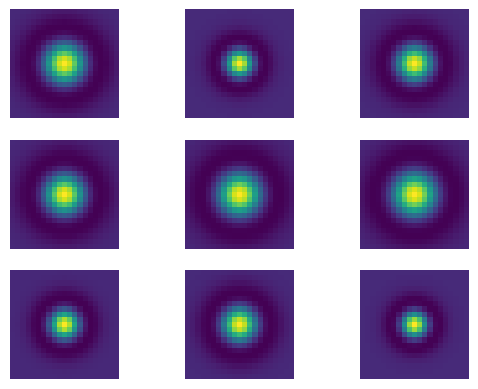

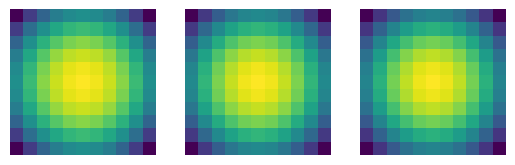

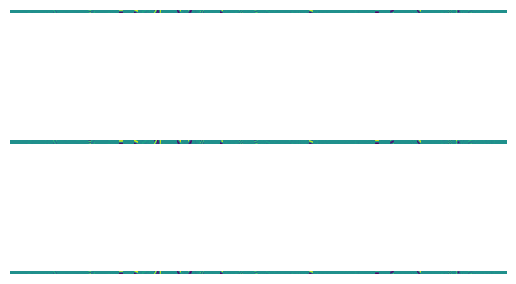

In [ ]:
__ = jax.tree_util.tree_map(lambda x: plot_filters(x), _)

In [ ]:
def check_trainable(path):
    # return ("A" in path) or ("alpha_chrom_rg" in path) or ("alpha_chrom_yb" in path)
    train = False
    if not config.A_GDNSPATIOFREQORIENT:
        # return ("GDNSpatioFreqOrient_0" in path) and ("A" in path)
        if ("GDNSpatioFreqOrient_0" in path) and ("A" in path):
            train = True
    if not config.TRAIN_JH:
        train = "Color" in path
    return train

In [5]:
trainable_tree = freeze(flax.traverse_util.path_aware_map(lambda path, v: "non_trainable" if check_trainable(path)  else "trainable", state.params))
trainable_tree

FrozenDict({
    GDN_0: {
        Conv_0: {
            kernel: 'trainable',
            bias: 'trainable',
        },
    },
    Color: {
        kernel: 'non_trainable',
    },
    GDN_1: {
        Conv_0: {
            kernel: 'trainable',
            bias: 'trainable',
        },
    },
    CenterSurroundLogSigmaK_0: {
        logsigma: 'trainable',
        K: 'trainable',
        A: 'trainable',
    },
    GDNGaussian_0: {
        GaussianLayerGamma_0: {
            gamma: 'trainable',
            A: 'trainable',
            bias: 'trainable',
        },
    },
    GaborLayerGammaRepeat_0: {
        freq: 'trainable',
        gammax: 'trainable',
        gammay: 'trainable',
        theta: 'trainable',
        sigma_theta: 'trainable',
        phase: 'trainable',
        A: 'trainable',
    },
    GDNSpatioFreqOrient_0: {
        bias: 'trainable',
        GaussianLayerGamma_0: {
            gamma: 'trainable',
            A: 'trainable',
        },
        FreqOrientGaussianGamma

In [ ]:
optimizers = {
    "trainable": optax.adam(learning_rate=config.LEARNING_RATE),
    "non_trainable": optax.set_to_zero(),
}

In [ ]:
tx = optax.multi_transform(optimizers, trainable_tree)

In [ ]:
state = create_train_state(PerceptNet(), random.PRNGKey(config.SEED), tx, input_shape=(1,384,512,3))
state = state.replace(params=clip_layer(state.params, "GDN", a_min=0))

In [6]:
param_count = sum(x.size for x in jax.tree_util.tree_leaves(state.params))
trainable_param_count = sum([w.size if t=="trainable" else 0 for w, t in zip(jax.tree_util.tree_leaves(state.params), jax.tree_util.tree_leaves(trainable_tree))])
param_count, trainable_param_count

(1849, 1840)

In [ ]:
wandb.run.summary["total_parameters"] = param_count
wandb.run.summary["trainable_parameters"] = trainable_param_count

In [ ]:
from perceptualtests.color_matrices import Mng2xyz, Mxyz2atd

In [ ]:
inputs = jnp.ones(shape=(1,28,28,3))

In [ ]:
inputs_atd = inputs @ Mng2xyz.T @ Mxyz2atd.T

In [7]:
Mng2xyz.T @ Mxyz2atd.T

array([[ 39.0454 ,  30.1207 ,  14.27948],
       [115.8404 , -63.3502 ,  41.26816],
       [ 16.3118 ,  30.2934 , -61.51888]])

In [ ]:
state = state.replace(params=unfreeze(state.params))

# ## DN 0 (Gamma)
state.params["GDN_0"]["Conv_0"]["bias"] = jnp.ones_like(state.params["GDN_0"]["Conv_0"]["bias"])*0.1
state.params["GDN_0"]["Conv_0"]["kernel"] = jnp.ones_like(state.params["GDN_0"]["Conv_0"]["kernel"])*0.5

## Opponent color channel transformation
if config.INIT_JH:
    # state.params["Conv_0"]["kernel"] = jnp.array([[39.0454,30.1207,14.27948],
    #                                               [115.8404,-63.3502,41.26816],
    #                                               [16.3118,30.2934,-61.51888]])[None,None,:,:]/163.5217
    state.params["Color"]["kernel"] = jnp.array([[39.0454,30.1207,14.27948],
                                                  [115.8404,-63.3502,41.26816],
                                                  [16.3118,30.2934,-61.51888]])[None,None,:,:]/163.5217

## Center Surround
state.params["CenterSurroundLogSigmaK_0"]["K"] = jnp.array([1.1,1.01,1.01,
                                                            1.01,1.1,1.01,
                                                            1.01,1.01,1.1])
state.params["CenterSurroundLogSigmaK_0"]["A"] = jnp.array([1.,0.,0.,
                                                            0.,1.,0.,
                                                            0.,0.,1.])

## GDNGaussian
state.params["GDNGaussian_0"]["GaussianLayerGamma_0"]["gamma"] = jnp.ones_like(state.params["GDNGaussian_0"]["GaussianLayerGamma_0"]["gamma"])*(1./0.04)
state.params["GDNGaussian_0"]["GaussianLayerGamma_0"]["bias"] = jnp.ones_like(state.params["GDNGaussian_0"]["GaussianLayerGamma_0"]["bias"])*0.1

## GDNSpatioFreqOrient
state.params["GDNSpatioFreqOrient_0"]["GaussianLayerGamma_0"]["gamma"] = jnp.ones_like(state.params["GDNSpatioFreqOrient_0"]["GaussianLayerGamma_0"]["gamma"])*(1./0.1)
# state.params["GDNSpatioFreqOrient_0"]["OrientGaussianGamma_0"]["gamma"] = jnp.ones_like(state.params["GDNSpatioFreqOrient_0"]["OrientGaussianGamma_0"]["gamma"])*(1/20)
# state.params["GDNSpatioFreqOrient_0"]["bias"] = jnp.tile(jnp.array([0.001, 0.002, 0.0035, 0.01])/100, reps=config.N_ORIENTATIONS*2)


state = state.replace(params=freeze(state.params))

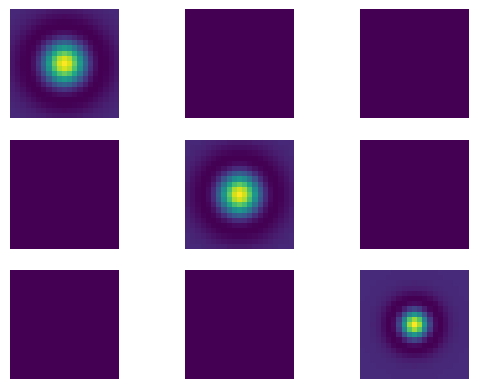

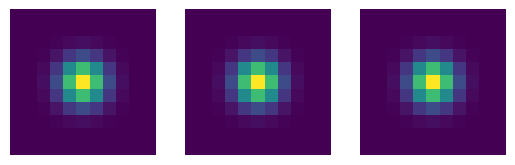

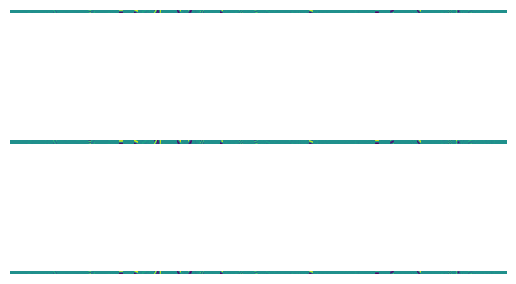

In [ ]:
pred, _ = state.apply_fn({"params": state.params, **state.state}, jnp.ones(shape=(1,384,512,3)), train=True, mutable=list(state.state.keys()))
__ = jax.tree_util.tree_map(lambda x: plot_filters(x), _)

Before actually training the model we're going to set up the checkpointer to be able to save our trained models:

In [ ]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(state)

In [ ]:
metrics_history = {
    "train_loss": [],
    "val_loss": [],
}

In [ ]:
batch = next(iter(dst_train_rdy.as_numpy_iterator()))

In [ ]:
from functools import partial

In [ ]:
@jax.jit
def forward(state, inputs):
    return state.apply_fn({"params": state.params, **state.state}, inputs, train=False)

In [ ]:
@jax.jit
def forward_intermediates(state, inputs):
    return state.apply_fn({"params": state.params, **state.state}, inputs, train=False, capture_intermediates=True)

In [8]:
%%time
outputs = forward(state, batch[0])
outputs.shape

CPU times: user 10.3 s, sys: 3.57 s, total: 13.8 s
Wall time: 11.1 s


(64, 96, 128, 128)

In [ ]:
%%time
s1, grads = train_step(state, batch, return_grads=True)

CPU times: user 59.6 s, sys: 21.2 s, total: 1min 20s
Wall time: 1min 6s


In [ ]:
# jax.config.update("jax_debug_nans", True)

In [ ]:
def filter_extra(extra):
    def filter_intermediates(path, x):
        path = "/".join(path)
        if "Gabor" in path:
            return (x[0][0],)
        else: 
            return x
    extra = unfreeze(extra)
    extra["intermediates"] = flax.traverse_util.path_aware_map(filter_intermediates, extra["intermediates"])
    return freeze(extra)

In [ ]:
%%time
for epoch in range(config.EPOCHS):
    ## Training
    for batch in dst_train_rdy.as_numpy_iterator():
        state, grads = train_step(state, batch, return_grads=True)
        state = state.replace(params=clip_layer(state.params, "GDN", a_min=0))
        state = state.replace(params=clip_param(state.params, "A", a_min=0))
        state = state.replace(params=clip_param(state.params, "K", a_min=1+1e-5))
        wandb.log({f"{k}_grad": wandb.Histogram(v) for k, v in flatten_params(grads).items()}, commit=False)
        # state = compute_metrics(state=state, batch=batch)
        # break

    ## Log the metrics
    for name, value in state.metrics.compute().items():
        metrics_history[f"train_{name}"].append(value)
    
    ## Empty the metrics
    state = state.replace(metrics=state.metrics.empty())

    ## Evaluation
    for batch in dst_val_rdy.as_numpy_iterator():
        state = compute_metrics(state=state, batch=batch)
        # break
    for name, value in state.metrics.compute().items():
        metrics_history[f"val_{name}"].append(value)
    state = state.replace(metrics=state.metrics.empty())
    
    ## Obtain activations of last validation batch
    _, extra = forward_intermediates(state, batch[0])
    extra = filter_extra(extra) ## Needed because the Gabor layer has multiple outputs
    
    ## Checkpointing
    if metrics_history["val_loss"][-1] <= min(metrics_history["val_loss"]):
        orbax_checkpointer.save(os.path.join(wandb.run.dir, "model-best"), state, save_args=save_args, force=True) # force=True means allow overwritting.

    wandb.log({f"{k}": wandb.Histogram(v) for k, v in flatten_params(state.params).items()}, commit=False)
    wandb.log({f"{k}": wandb.Histogram(v) for k, v in flatten_params(extra["intermediates"]).items()}, commit=False)
    wandb.log({"epoch": epoch+1, **{name:values[-1] for name, values in metrics_history.items()}})
    print(f'Epoch {epoch} -> [Train] Loss: {metrics_history["train_loss"][-1]} [Val] Loss: {metrics_history["val_loss"][-1]}')
    # break

<class 'BrokenPipeError'>: [Errno 32] Broken pipe

Epoch 0 -> [Train] Loss: -0.7469671368598938 [Val] Loss: -0.8513321280479431
Epoch 1 -> [Train] Loss: -0.8588889837265015 [Val] Loss: -0.8581237196922302
Epoch 2 -> [Train] Loss: -0.8749226331710815 [Val] Loss: -0.8603856563568115
Epoch 3 -> [Train] Loss: -0.8785033822059631 [Val] Loss: -0.8656572103500366
Epoch 4 -> [Train] Loss: -0.8828904032707214 [Val] Loss: -0.8635718822479248
Epoch 5 -> [Train] Loss: -0.8908722996711731 [Val] Loss: -0.8704389333724976
Epoch 6 -> [Train] Loss: -0.8898577094078064 [Val] Loss: -0.8677831888198853
Epoch 7 -> [Train] Loss: -0.8907795548439026 [Val] Loss: -0.8722721934318542
Epoch 8 -> [Train] Loss: -0.8929575681686401 [Val] Loss: -0.8648291826248169
Epoch 9 -> [Train] Loss: -0.889065682888031 [Val] Loss: -0.8711928725242615
Epoch 10 -> [Train] Loss: -0.8994429111480713 [Val] Loss: -0.8754059076309204
Epoch 11 -> [Train] Loss: -0.8997451066970825 [Val] Loss: -0.8815215229988098
Epoch 12 -> [Train] Loss: -0.9043212532997131 [Val] Loss: -0.88468480110168

Save the final model as well in case we want to keep training from it or whatever:

In [ ]:
orbax_checkpointer.save(os.path.join(wandb.run.dir, "model-final"), state, save_args=save_args)

In [ ]:
wandb.finish()

<class 'BrokenPipeError'>: [Errno 32] Broken pipe

Exception in thread NetStatThr:
Traceback (most recent call last):
  File "/lhome/ext/uv075/uv0752/miniconda3/envs/testing_gpu/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/lhome/ext/uv075/uv0752/miniconda3/envs/testing_gpu/lib/python3.8/threading.py", line 870, in run
Exception in thread ChkStopThr:
Traceback (most recent call last):
  File "/lhome/ext/uv075/uv0752/miniconda3/envs/testing_gpu/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self._target(*self._args, **self._kwargs)
  File "/lhome/ext/uv075/uv0752/miniconda3/envs/testing_gpu/lib/python3.8/site-packages/wandb/sdk/wandb_run.py", line 260, in check_network_status
    self.run()
  File "/lhome/ext/uv075/uv0752/miniconda3/envs/testing_gpu/lib/python3.8/threading.py", line 870, in run
    self._loop_check_status(
  File "/lhome/ext/uv075/uv0752/miniconda3/envs/testing_gpu/lib/python3.8/site-packages/wandb/sdk/wandb_run.py", line 216, in _loop_check_status


In [ ]:
import matplotlib.pyplot as plt

<class 'KeyError'>: 'GaborLayerLogSigma__0'

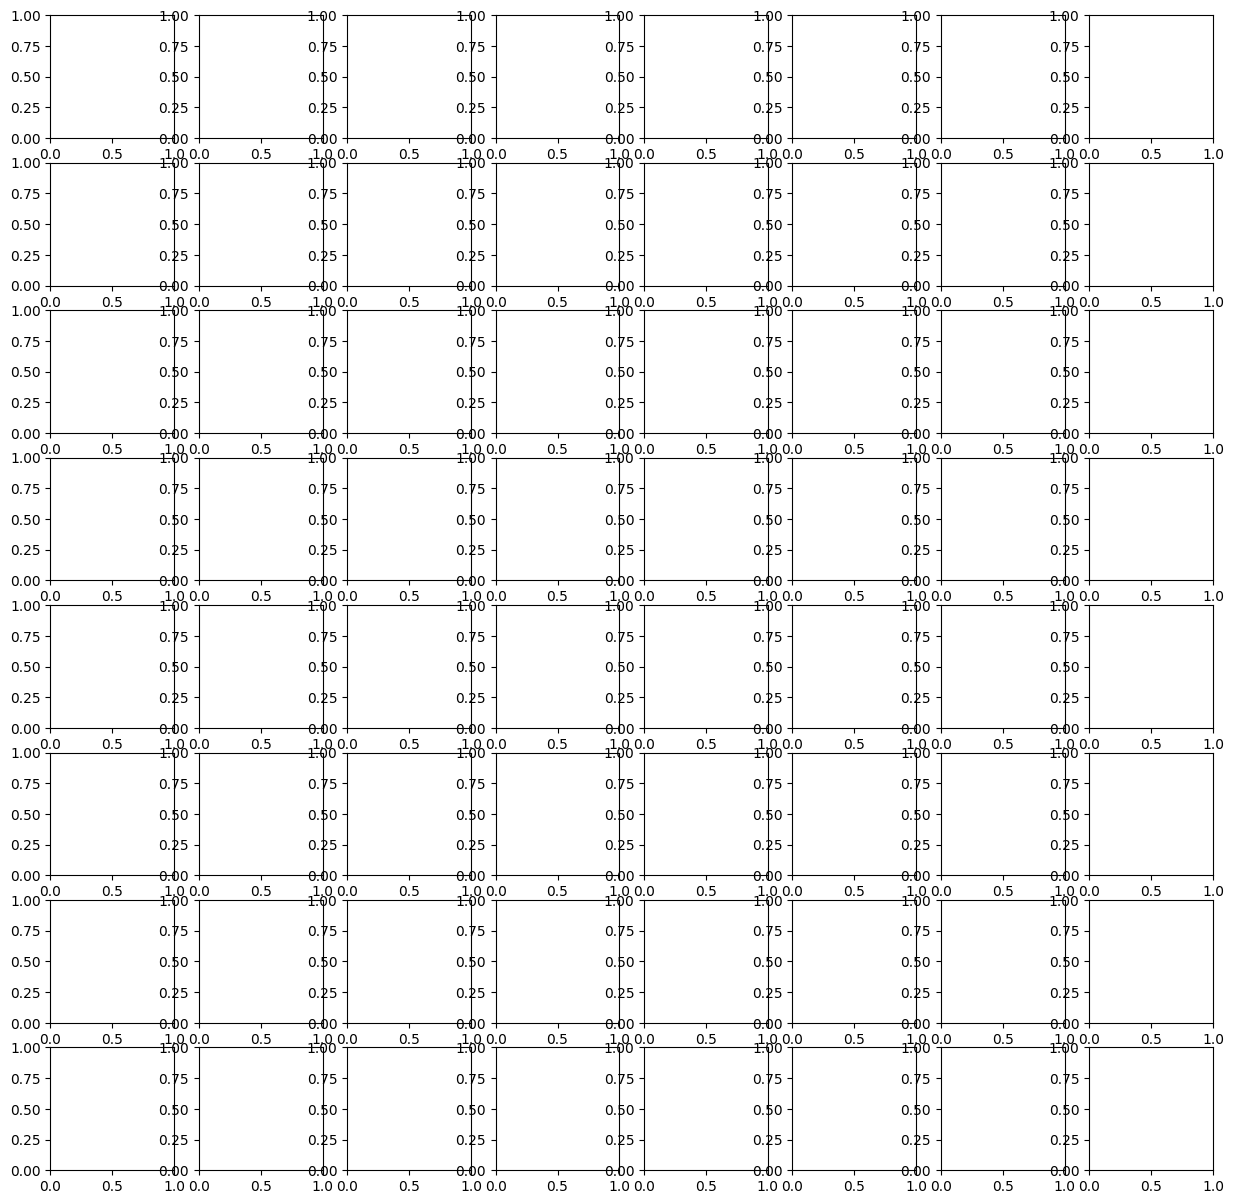

In [ ]:
fig, axes = plt.subplots(8,8, figsize=(15,15))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(state.state["precalc_filter"]["GaborLayerLogSigma__0"]["kernel"][:,:,0,i])
    ax.axis("off")
plt.show()

In [ ]:
kernel = state.state["precalc_filter"]["GaborLayerLogSigma_0"]["kernel"]
kernel.shape

<class 'KeyError'>: 'GaborLayerLogSigma_0'

In [ ]:
kernel_f_fft = jnp.fft.fftn(kernel[:,:,0,:], axes=(0,1))
kernel_f_fft = jnp.fft.fftshift(kernel_f_fft)
kernel_f_fft_abs_sum = jnp.abs(kernel_f_fft).sum(axis=-1)
kernel_f_fft.shape, kernel_f_fft_abs_sum.shape

<class 'NameError'>: name 'kernel' is not defined

<class 'NameError'>: name 'kernel_f_fft' is not defined

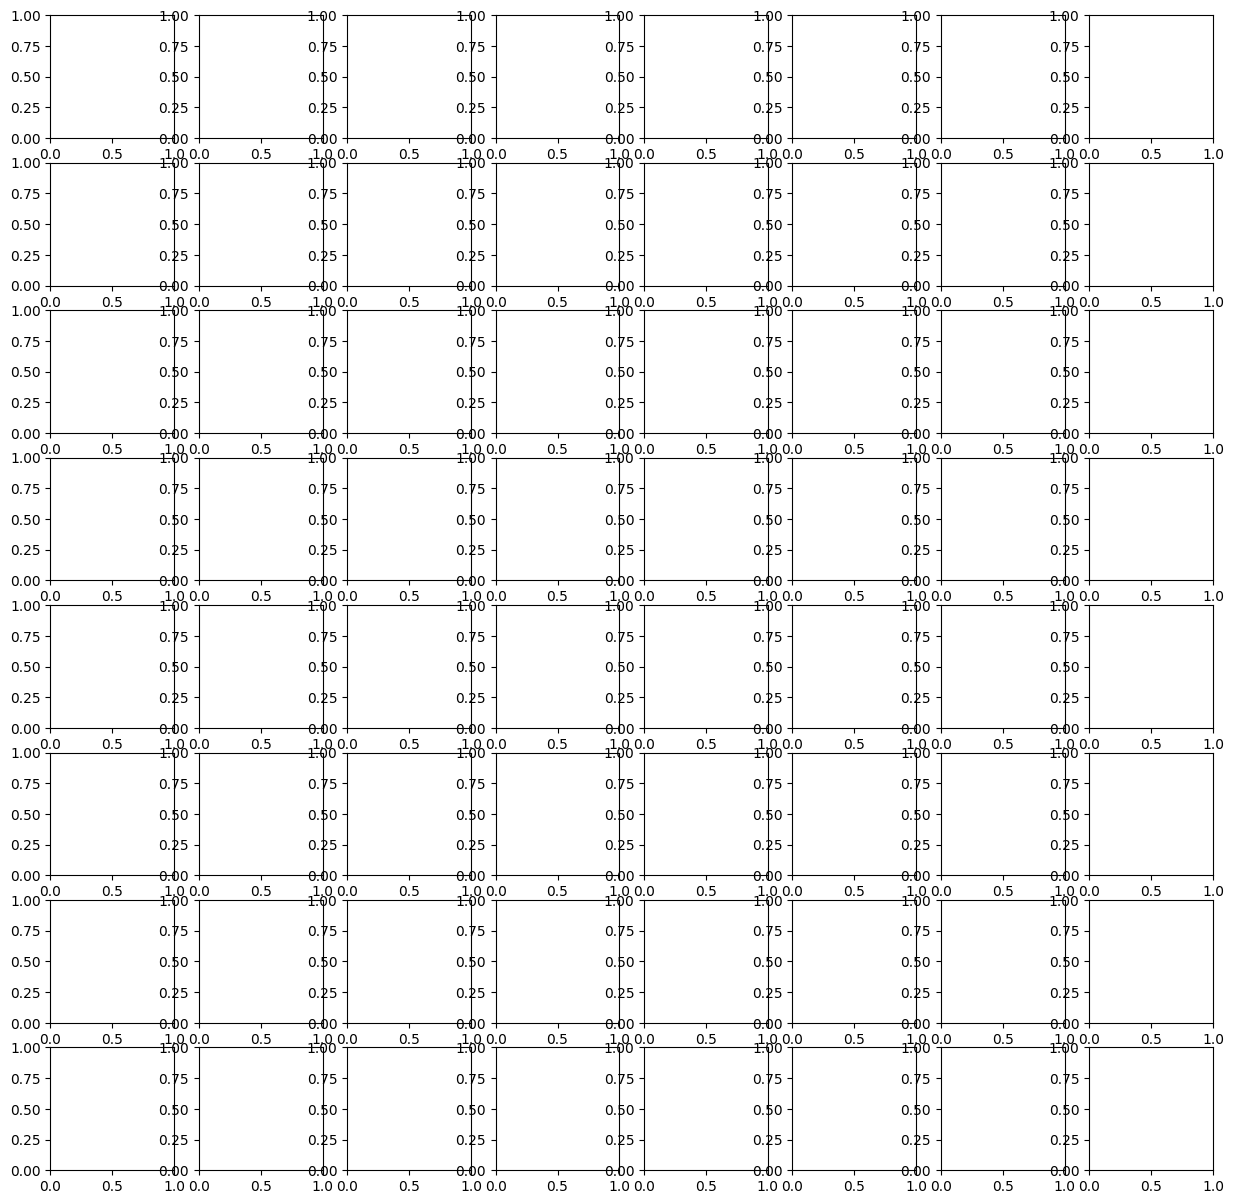

In [ ]:
fig, axes = plt.subplots(8,8, figsize=(15,15))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(jnp.abs(kernel_f_fft[:,:,i]))
    ax.axis("off")
plt.show()

In [ ]:
plt.imshow(kernel_f_fft_abs_sum)
plt.show()

<class 'NameError'>: name 'kernel_f_fft_abs_sum' is not defined